In [12]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi
from time import time as gettime

from library.fvm.solver import Solver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices

from library.model.model import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

In [13]:
class VAMHyperbolic(Model):
    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        dimension=1,
        fields=6,
        aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],
        parameters={},
        parameters_default={"g": 9.81},
        settings={},
        settings_default={},
    ):
        self.variables = register_sympy_attribute(fields, "q")
        self.n_fields = self.variables.length()
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_fields=aux_fields,
            parameters=parameters,
            parameters_default=parameters_default,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            settings={**settings_default, **settings},
        )
        
    def flux(self):
        fx = Matrix([0 for i in range(self.n_fields)])
        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        
        fx[0] = hu0
        fx[1] = hu0 * u0 + 1/3 * hu1 * u1
        fx[2] = 2*hu0 * u1
        fx[3] = hu0 * w0 + 1/3 * hu1 * w1
        fx[4] = hu0 * w1 + u1 * (hw0 + 2/5*hw2)
        
        return [fx]

    def nonconservative_matrix(self):
        nc = Matrix([[0 for i in range(self.n_fields)] for j in range(self.n_fields)])

        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        w2 = hw2 / h

        nc[1, 0] = param.g * h
        nc[1, 5] = param.g * h
        nc[2, 3] = -u0
        nc[4, 2] = + 1/5 * w2 - w0
        return [-nc]
    
    def eigenvalues(self):
        ev = Matrix([0 for i in range(self.n_fields)])
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h

        ev[0] = u0
        ev[1] = u0 + 1/sqrt(3) * u1
        ev[2] = u0 - 1/sqrt(3) * u1
        ev[3] = u0 + sqrt(param.g * h + u1**2)
        ev[4] = u0 - sqrt(param.g * h + u1**2)
        ev[5] = 0
        
        return ev

    def source_implicit(self):
        R = Matrix([0 for i in range(self.n_fields)])
        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        b = self.variables[5]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        w2 = hw2 /h  


        p0 = self.aux_variables.p0
        p1 = self.aux_variables.p1
        dbdx = self.aux_variables.dbdx
        dhdx = self.aux_variables.dhdx
        dhp0dx = self.aux_variables.dhp0dx
        dhp1dx = self.aux_variables.dhp1dx

        R[0] = 0.
        R[1] = dhp0dx + 2 * p1 * dbdx 
        R[2] = dhp1dx - (3*p0 - p1)*dhdx  -6*(p0-p1)*dbdx
        R[3] = -2*p1
        R[4] = 6*(p0-p1)
        R[5] = 0.
        return R
        


In [ ]:
class VAMPoisson(Model):
    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        dimension=1,
        fields=['p0', 'p1'],
        aux_fields=['dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx', 'd4p0dx4', 'd4p1dx4', 'h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx', 'dt'],
        parameters={},
        parameters_default={"g": 9.81},
        settings={},
        settings_default={},
    ):
        self.variables = register_sympy_attribute(fields, "q")
        self.n_fields = self.variables.length()
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_fields=aux_fields,
            parameters=parameters,
            parameters_default=parameters_default,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            settings={**settings_default, **settings},
        )

    def source_implicit(self):
        R = Matrix([0 for i in range(self.n_fields)])

        h = self.aux_variables.h
        p0 = self.variables.p0
        p1 = self.variables.p1
        dt = self.aux_variables.dt

        dbdx   = self.aux_variables.dbdx
        ddbdxx = self.aux_variables.ddbdxx

        dhdx   = self.aux_variables.dhdx
        ddhdxx = self.aux_variables.ddhdxx
        
        dp0dx = self.aux_variables.dp0dx
        dp1dx = self.aux_variables.dp1dx
        ddp0dxx = self.aux_variables.ddp0dxx
        ddp1dxx = self.aux_variables.ddp1dxx

        d4p0dx4 = self.aux_variables.d4p0dx4
        d4p1dx4 = self.aux_variables.d4p1dx4
        
        
        #Note, these are not truly the values from the old time step, but rather the values from the middle state after hyperbolic step
        oldu0 = self.aux_variables.u0
        doldu0dx = self.aux_variables.du0dx
        oldw1 = self.aux_variables.w1
        oldw0 = self.aux_variables.w0
        oldu1 = self.aux_variables.u1
        doldu1dx = self.aux_variables.du1dx

        delta4 = 0.00
        delta2 = 0.0
        #I1 = 0.666666666666667*dt*dp0dx - 2*(-dt*(h*ddp0dxx + p0*dhdx + 2*p1*dbdx) + h*dp1dx)*dbdx/h + 2*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp0dx + p1*dhdx) + h*u1)/h + 0.333333333333333*(2*dt*p1 + h*u0)*dhdx/h + (-(-dt*(h*ddp0dxx + p0*dhdx + 2*p1*dbdx) + h*dp1dx)*dhdx/h**2 + (-dt*(h*du1dx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp0dx + 2*dhdx*ddp0dxx) + h*dhdx + dp1dx*dhdx)/h)*h + 0.333333333333333*h*du0dx + 0.333333333333333*u0*dhdx + delta * ddp0dxx
        #I2 = -2*(-dt*(6*p0 - 6*p1) + h*w0)/h + 2*(2*dt*p1 + h*u0)*dbdx/h + (2*dt*p1 + h*u0)*dhdx/h + (-(-dt*(h*ddp0dxx + p0*dhdx + 2*p1*dbdx) + h*dp1dx)*dhdx/h**2 + (-dt*(h*du1dx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp0dx + 2*dhdx*ddp0dxx) + h*dhdx + dp1dx*dhdx)/h)*h + delta * ddp1dxx
        # I1 = 0.666666666666667*dt*dhp1dx/h - 0.666666666666667*dt*hp1*dhdx/h**2 - 2*(-dt*(dhp0dx + 2*hp1*dbdx/h) + h*u0)*dbdx/h + 2*(-dt*(-(3*hp0/h - hp1/h)*dhdx - (6*hp0/h - 6*hp1/h)*dbdx + dhp1dx) + h*w0)/h + 0.333333333333333*(2*dt*hp1/h + h*u1)*dhdx/h + (-(-dt*(dhp0dx + 2*hp1*dbdx/h) + h*u0)*dhdx/h**2 + (-dt*(ddhp0dxx + 2*hp1*ddbdxx/h + 2*dbdx*dhp1dx/h - 2*hp1*dbdx*dhdx/h**2) + h*du0dx + u0*dhdx)/h)*h + 0.333333333333333*h*du1dx + 0.333333333333333*u1*dhdx + delta *ddhp0dxx
        # I2 = -2*(-dt*(6*hp0/h - 6*hp1/h) + h*w1)/h + 2*(2*dt*hp1/h + h*u1)*dbdx/h + (2*dt*hp1/h + h*u1)*dhdx/h + (-(-dt*(dhp0dx + 2*hp1*dbdx/h) + h*u0)*dhdx/h**2 + (-dt*(ddhp0dxx + 2*hp1*ddbdxx/h + 2*dbdx*dhp1dx/h - 2*hp1*dbdx*dhdx/h**2) + h*du0dx + u0*dhdx)/h)*h + delta *ddhp1dxx
        #I1 = 0.666666666666667*dt*dp1dx - 2*(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dbdx/h + 2*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldw0)/h + 0.333333333333333*(2*dt*p1 + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + 0.333333333333333*h*doldu1dx + 0.333333333333333*oldu1*dhdx +delta *ddp0dxx
        #I2 = -2*(-dt*(6*p0 - 6*p1) + h*oldw1)/h + 2*(2*dt*p1 + h*oldu1)*dbdx/h + (2*dt*p1 + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + delta *ddp1dxx
        #I1 = h + 0.333333333333333*(2*dt*p1 + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + 0.333333333333333*h*doldu1dx + 0.333333333333333*oldu1*dhdx +delta *ddp0dxx
        #I2 = -2*(-dt*(6*p0 - 6*p1) + h*oldw1)/h + 2*(2*dt*p1 + h*oldu1)*dbdx/h + (2*dt*p1 + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + delta *ddp1dxx
        #I1 = 0.666666666666667*dt*dp1dx - 2*(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dbdx/h + 2*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldw0)/h + 0.333333333333333*(2*dt*p1 + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + 0.333333333333333*h*doldu1dx + 0.333333333333333*oldu1*dhdx + delta * d4p0dx4
        #I2 = -2*(-dt*(6*p0 - 6*p1) + h*oldw1)/h + 2*(2*dt*p1 + h*oldu1)*dbdx/h + (2*dt*p1 + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + delta * d4p1dx4
        #I2 = delta * d4p1dx4
        I1 = -0.333333333333333*dt*(-(3*p0 - p1)*ddhdxx - (6*p0 - 6*p1)*ddbdxx - (3*dp0dx - dp1dx)*dhdx - (6*dp0dx - 6*dp1dx)*dbdx + h*ddp1dxx + p1*ddhdxx + 2*dhdx*dp1dx) - 2*(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dbdx/h + 0.333333333333333*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dhdx/h + 2*(2*dt*p1 + h*oldw0)/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + 0.333333333333333*h*doldu1dx + 0.333333333333333*oldu1*dhdx + delta2 * ddp0dxx + delta4 *d4p0dx4
        I2 =-2*(-dt*(6*p0 - 6*p1) + h*oldw1)/h + 2*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dbdx/h + (-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + delta2 * ddp1dxx + delta4 * d4p1dx4
        R[0] = I1 
        R[1] = I2

        return R
    
    def eigenvalues(self):
        ev = Matrix([0 for i in range(self.n_fields)])
        return ev


In [15]:


class HyperbolicSolver(Solver):

    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):

        h=Q[0]
        hu0=Q[1]
        hu1=Q[2]
        hw0=Q[3]
        hw1=Q[4]
        b=Q[5]
        
        w0 = hw0 / h
        w1 = hw1 / h
        u0 = hu0 / h
        u1 = hu1 / h
        # aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],

        dbdx  = compute_derivatives(b, mesh, derivatives_multi_index=([[1]]))[:,0]
        Qaux = Qaux.at[3].set(dbdx)
        
        hw2 = h*(-(w0 + w1) + (u0 + u1) * dbdx)
        Qaux = Qaux.at[0].set(hw2)
        
        
        dhdx   = compute_derivatives(h, mesh, derivatives_multi_index=([[1]]))[:, 0]
        Qaux = Qaux.at[4].set(dhdx)
        return Qaux
    
    # @partial(jax.jit, static_argnames=["self", "mesh", "pde"])
    def compute_source_pressure(self, mesh, pde):
        @jax.jit
        def f(dt, Q, Qaux, parameters):
            dQ = jnp.zeros_like(Q)
            dQ = dQ.at[:, : mesh.n_inner_cells].set(
                pde.source_implicit(
                    Q[:, : mesh.n_inner_cells],
                    Qaux[:, : mesh.n_inner_cells],
                    parameters,
                )
            )
            return Q - dt * dQ
        return f


In [16]:

class PoissonSolver(Solver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):

        p0 = Q[0]
        p1 = Q[1]
        

        #  aux_fields=[ 'dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx', 'h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx', 'dt'],

        dp0dx = compute_derivatives(p0, mesh, derivatives_multi_index=([[1]]))[:, 0]
        ddp0dxx = compute_derivatives(p0, mesh, derivatives_multi_index=([[2]]))[:, 0]
        dp1dx = compute_derivatives(p1, mesh, derivatives_multi_index=([[1]]))[:, 0]
        ddp1dxx = compute_derivatives(p1, mesh, derivatives_multi_index=([[2]]))[:, 0]

        d4p0dx4 = compute_derivatives(p0, mesh, derivatives_multi_index=([[4]]))[:, 0]
        d4p1dx4 = compute_derivatives(p1, mesh, derivatives_multi_index=([[4]]))[:, 0]

        Qaux = Qaux.at[0].set(dp0dx)
        Qaux = Qaux.at[1].set(ddp0dxx)
        Qaux = Qaux.at[2].set(dp1dx)
        Qaux = Qaux.at[3].set(ddp1dxx)
        Qaux = Qaux.at[4].set(d4p0dx4)
        Qaux = Qaux.at[5].set(d4p1dx4)

        return Qaux


In [17]:
def solve_vam(
    mesh, model1, model2, settings, ode_solver_flux=RK1, ode_solver_source=RK1
):
    solverQ = HyperbolicSolver()
    solverP = PoissonSolver()
    
    Q, Qaux = solverQ.initialize(model1, mesh)
    P, Paux = solverP.initialize(model2, mesh)

    parameters1 = model1.parameter_values
    parameters2 = model2.parameter_values

    parameters1 = jnp.asarray(parameters1)
    parameters2 = jnp.asarray(parameters2)
    
    mesh = convert_mesh_to_jax(mesh)


    pde1, bcs1 = solverQ._load_runtime_model(model1)
    pde2, bcs2 = solverP._load_runtime_model(model2)
    output_hdf5_path = os.path.join(settings.output_dir, f"{settings.name}.h5")
    save_fields = io.get_save_fields(output_hdf5_path, settings.output_write_all)

    def run(Q, Qaux, parameters1, pde1, bcs1, P, Paux, parameters2, pde2, bcs2):
        iteration = 0.0
        time = 0.0
        assert model1.dimension == mesh.dimension
        assert model2.dimension == mesh.dimension

        i_snapshot = 0.0
        dt_snapshot = settings.time_end / (settings.output_snapshots - 1)
        io.init_output_directory(settings.output_dir, settings.output_clean_dir)
        mesh.write_to_hdf5(output_hdf5_path)
        _ = save_fields(time, 0.0, i_snapshot, Q, Qaux)
        i_snapshot = save_fields(time, 0.0, i_snapshot, Q, Qaux)

        Q0 = Q
        Qnew = Q
        Pnew = P
        Qauxnew = Qaux
        Pauxnew = Paux

        min_inradius = jnp.min(mesh.cell_inradius)


        compute_max_abs_eigenvalue = solverQ.get_compute_max_abs_eigenvalue(
            mesh, pde1, settings
        )
        space_solution_operator = solverQ.get_space_solution_operator(
            mesh, pde1, bcs1, settings
        )
        source_operator = solverQ.get_compute_source(mesh, pde1, settings)
        boundary_operator1 = solverQ.get_apply_boundary_conditions(mesh, bcs1)
        
        source_operator2 = solverP.get_compute_source(mesh, pde2, settings)
        boundary_operator2 = solverP.get_apply_boundary_conditions(mesh, bcs2)
        
        pressure_correction = solverQ.compute_source_pressure(mesh, pde1)

        time_start = gettime()

        @jax.jit
        def time_loop(time, iteration, i_snapshot, Q, Qaux, Pnew, Paux, Qold, Qauxold, Pold, Pauxold):
            loop_val = (time, iteration, i_snapshot, Q, Qaux, Pnew, Paux, Qold, Qauxold, Pold, Pauxold)

            def loop_body(init_value):
                time, iteration, i_snapshot, Q, Qaux, P, Paux, Qold, Qauxold, Pold, Pauxold = init_value

                dt = settings.compute_dt(
                    Q, Qaux, parameters1, min_inradius, compute_max_abs_eigenvalue
                )
                
                def step(Q, Qaux, P, Paux):

                    #############################################################
                    #####################VELOCITY PREDICTOR######################
                    #############################################################
                    Qauxnew = solverQ.update_qaux(
                        Q, Qaux, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    )
                    Q1 = ode_solver_flux(
                        space_solution_operator, Q, Qauxnew, parameters1, dt
                    )

                    Q1 = Q1.at[5].set(Q0[5])

                    Qauxnew = solverQ.update_qaux(
                        Q1, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    )
                    #Qnew = ode_solver_source(
                    #    source_operator,
                    #    Q1,
                    #    Qauxnew,
                    #    parameters1,
                    #    dt,
                    #    func_jac=solverQ.compute_source_jac,
                    #)

                    #Qauxnew = solverQ.update_qaux(
                    #    Qnew, Qauxnew, Q, Qaux, mesh, pde1, parameters1, time, dt
                    #)
                    Qnew = Q1
                    Qnew = boundary_operator1(time, Qnew, Qauxnew, parameters1)


                    #############################################################
                    #########################PRESSURE############################
                    #############################################################
                    
                    #        aux_fields=['dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx','h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx'],
                    #         aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],

                    h = Q[0]
                    u0 = Q[1]/h
                    u1 = Q[2]/h
                    w0 = Q[3]/h
                    w1 = Q[4]/h
                    b = Q[5]
                    
                    dbdx = Qaux[3]
                    ddbdxx = compute_derivatives(b, mesh, derivatives_multi_index=([[2]]))[:, 0]
                    dhdx = Qaux[4]
                    ddhdxx = compute_derivatives(h, mesh, derivatives_multi_index=([[2]]))[:, 0]
                    du0dx = compute_derivatives(u0, mesh, derivatives_multi_index=([[1]]))[:, 0]
                    du1dx = compute_derivatives(u1, mesh, derivatives_multi_index=([[1]]))[:, 0]

                    offset = 2
                    Paux = Paux.at[4+offset].set(h)
                    Paux = Paux.at[5+offset].set(dbdx)
                    Paux = Paux.at[6+offset].set(ddbdxx)
                    Paux = Paux.at[7+offset].set(dhdx)
                    Paux = Paux.at[8+offset].set(ddhdxx)
                    Paux = Paux.at[9+offset].set(u0)
                    Paux = Paux.at[10+offset].set(du0dx)
                    Paux = Paux.at[11+offset].set(w0)
                    Paux = Paux.at[12+offset].set(w1)
                    Paux = Paux.at[13+offset].set(u1)
                    Paux = Paux.at[14+offset].set(du1dx)
                    Paux = Paux.at[15+offset].set(dt)

                    Paux = solverP.update_qaux(
                        P, Paux, Pold, Pauxold, mesh, pde2, parameters2, time, dt
                    )

                    def residual(P):

                    
                        # dp0dx = compute_derivatives(P[0], mesh, derivatives_multi_index=([[1]]))[:, 0]
                        # ddp0dxx = compute_derivatives(P[0], mesh, derivatives_multi_index=([[2]]))[:, 0]
                        # dp1dx = compute_derivatives(P[1], mesh, derivatives_multi_index=([[1]]))[:, 0]
                        # ddp1dxx = compute_derivatives(P[1], mesh, derivatives_multi_index=([[2]]))[:, 0]


                        paux = solverP.update_qaux(P, Paux, Pold, Pauxold, mesh, pde2, parameters2, time, dt)

                        res = pde2.source_implicit(P, paux, parameters2)
                        res = res.at[:, mesh.n_inner_cells:].set(0.)
                        return res


                    Pnew = solverP.implicit_solve(P, Paux, Pold, Pauxold, mesh, model2, pde2, parameters2, time, dt, boundary_operator2, debug=[True, False], user_residual=residual)

                    ############################################################
                    ########################CORRECTOR###########################
                    ############################################################
                    
                    #         aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],
                    Pauxnew = solverP.update_qaux(
                        Pnew, Paux, Pold, Pauxold, mesh, pde2, parameters2, time, dt
                    )
                    Qauxnew = Qauxnew.at[1].set(Pnew[0])
                    Qauxnew = Qauxnew.at[2].set(Pnew[1])
                    h =  Qnew[0]
                    
                    dhp0dx = compute_derivatives(h*Pnew[0], mesh, derivatives_multi_index=([[1]]))[:, 0]
                    dhp1dx = compute_derivatives(h*Pnew[1], mesh, derivatives_multi_index=([[1]]))[:, 0]

                    Qauxnew = Qauxnew.at[5].set(dhp0dx)
                    Qauxnew = Qauxnew.at[6].set(dhp1dx)
                    # Qauxnew = solverQ.update_qaux(
                    #     Qnew, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    # )
                    # Qnew = boundary_operator1(time, Qnew, Qauxnew, parameters1)

                    Qnew = pressure_correction(dt, Qnew, Qauxnew, parameters1)
                    Qauxnew = solverQ.update_qaux(
                        Qnew, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    )
                    Qnew = boundary_operator1(time, Qnew, Qauxnew, parameters1)
                    return Qnew, Qauxnew, Pnew, Pauxnew
            
                Qnew, Qauxnew, Pnew, Pauxnew = step(Q, Qaux, P, Paux)
                Qnew, Qauxnew, Pnew, Pauxnew = step(Qnew, Qauxnew, Pnew, Pauxnew)
                Qnew = 0.5 * (Qold + Qnew)
                Pnew = 0.5 * (Pold + Pnew)
                Qauxnew = solverQ.update_qaux(
                    Qnew, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt)
                
                # Update solution and time
                time += dt
                iteration += 1
                
                time_stamp = (i_snapshot + 1) * dt_snapshot

                jax.debug.print(
                    "iteration: {iteration}, time: {time}, dt: {dt}, i_snapshot: {i_snapshot}, time_stamp: {time_stamp}",
                    iteration=iteration,
                    time=time,
                    dt=dt,
                    i_snapshot=i_snapshot,
                    time_stamp=time_stamp
                )
                i_snapshot = save_fields(time, time_stamp, i_snapshot, Qnew, Qauxnew)


                return (time, iteration, i_snapshot, Qnew, Qauxnew, Pnew, Pauxnew, Q, Qaux, P, Paux)

            def proceed(loop_val):
                time, iteration, i_snapshot, Q, Qaux, P, Paux, Qold, Qauxold, Pold, Pauxold = loop_val
                return time < settings.time_end

            (time, iteration, i_snapshot, Q, Qaux, P, Paux, Qold, Qauxold, Pold, Pauxold) = jax.lax.while_loop(
                proceed, loop_body, loop_val
            )
            
            return P, Paux

        P, Paux = time_loop(time, iteration, i_snapshot, Qnew, Qauxnew, Pnew, Pauxnew, Q, Qaux, P, Paux)
        return P, Paux

    time_start = gettime()
    P, Paux = run(Q, Qaux, parameters1, pde1, bcs1, P, Paux, parameters2, pde2, bcs2)

    print(f"Runtime: {gettime() - time_start}")

    return P, Paux



In [20]:


settings = Settings(
    name="VAM",
    compute_dt=timestepping.adaptive(CFL=0.4),
    time_end=50.,
    output_snapshots=100,
    output_dir="outputs/vam",
)

bc_tags = ["left", "right"]
bc_tags_periodic_to = ["right", "left"]

bcs1 = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag='left', prescribe_fields={
            1: lambda t, x, dx, q, qaux, p, n: .11197,
            2: lambda t, x, dx, q, qaux, p, n: 0.,
            3: lambda t, x, dx, q, qaux, p, n: 0.,
            4: lambda t, x, dx, q, qaux, p, n: 0.
        }),
        BC.Extrapolation(physical_tag='right')

    ]
)

bcs2 = BC.BoundaryConditions(
    [
        BC.Extrapolation(physical_tag='left'),
        BC.Extrapolation(physical_tag='right'),
    ]
)

def custom_ic1(x):
    Q = np.zeros(6, dtype=float)
    Q[1] = np.where(x[0]-5 < 1, 0.0, 0.)
    Q[5] = 0.20*np.exp(-(x[0]-0.)**2 / (2*0.2**2)) 
    Q[0] = np.where(x[0] < 1, 0.34, 0.015) - Q[5]
    Q[0] = np.where(Q[0] > 0.015, Q[0], 0.015)
    # Q[0] = np.where(x[0]**2 < 0.5, 0.2, 0.1)
    return Q

def custom_ic2(x):
    Q = np.zeros(2, dtype=float)
    return Q

ic1 = IC.UserFunction(custom_ic1)
ic2 = IC.UserFunction(custom_ic2)


model1 = VAMHyperbolic(
    parameters={"g": 9.81},
    boundary_conditions=bcs1,
    initial_conditions=ic1,
    settings={},
)

model2 = VAMPoisson(
    parameters={"g": 9.81},
    boundary_conditions=bcs2,
    initial_conditions=ic2,
    settings={},
)

mesh = petscMesh.Mesh.create_1d((-1.5, 1.5), 60, lsq_degree=2)

Q, Qaux = solve_vam(
    mesh,
    model1,
    model2,
    settings,
)
io.generate_vtk(os.path.join(settings.output_dir, f"{settings.name}.h5"))



iteration: 1.0, time: 0.01095105684851627, dt: 0.01095105684851627, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 0.000e+00
Newton Iter 0: residual norm = 2.332e+00
Newton Iter 1: residual norm = 5.153e-06
Newton Iter 2: residual norm = 3.885e-12
iteration: 2.0, time: 0.020926463924177713, dt: 0.009975407075661441, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 5.959e-01
Newton Iter 1: residual norm = 4.867e-07
Newton Iter 0: residual norm = 8.838e-01
Newton Iter 1: residual norm = 6.256e-07
iteration: 3.0, time: 0.030869248991761165, dt: 0.009942785067583452, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 6.168e-01
Newton Iter 1: residual norm = 4.109e-07
Newton Iter 0: residual norm = 8.713e-01
Newton Iter 1: residual norm = 7.029e-07
iteration: 4.0, time: 0.04039799004889763, dt: 0.00952874105713647, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 4.496e-01

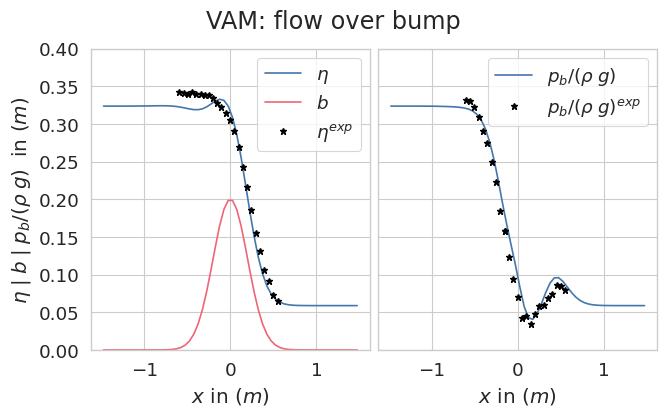

In [21]:
fig = plots_paper.plot_vam(os.path.join(settings.output_dir, settings.name + ".h5"))